In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils as np_utils

/Users/jagatmohithandhavarapu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [27]:

data = pd.read_csv('fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [3]:

data.shape

(35887, 3)

In [4]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

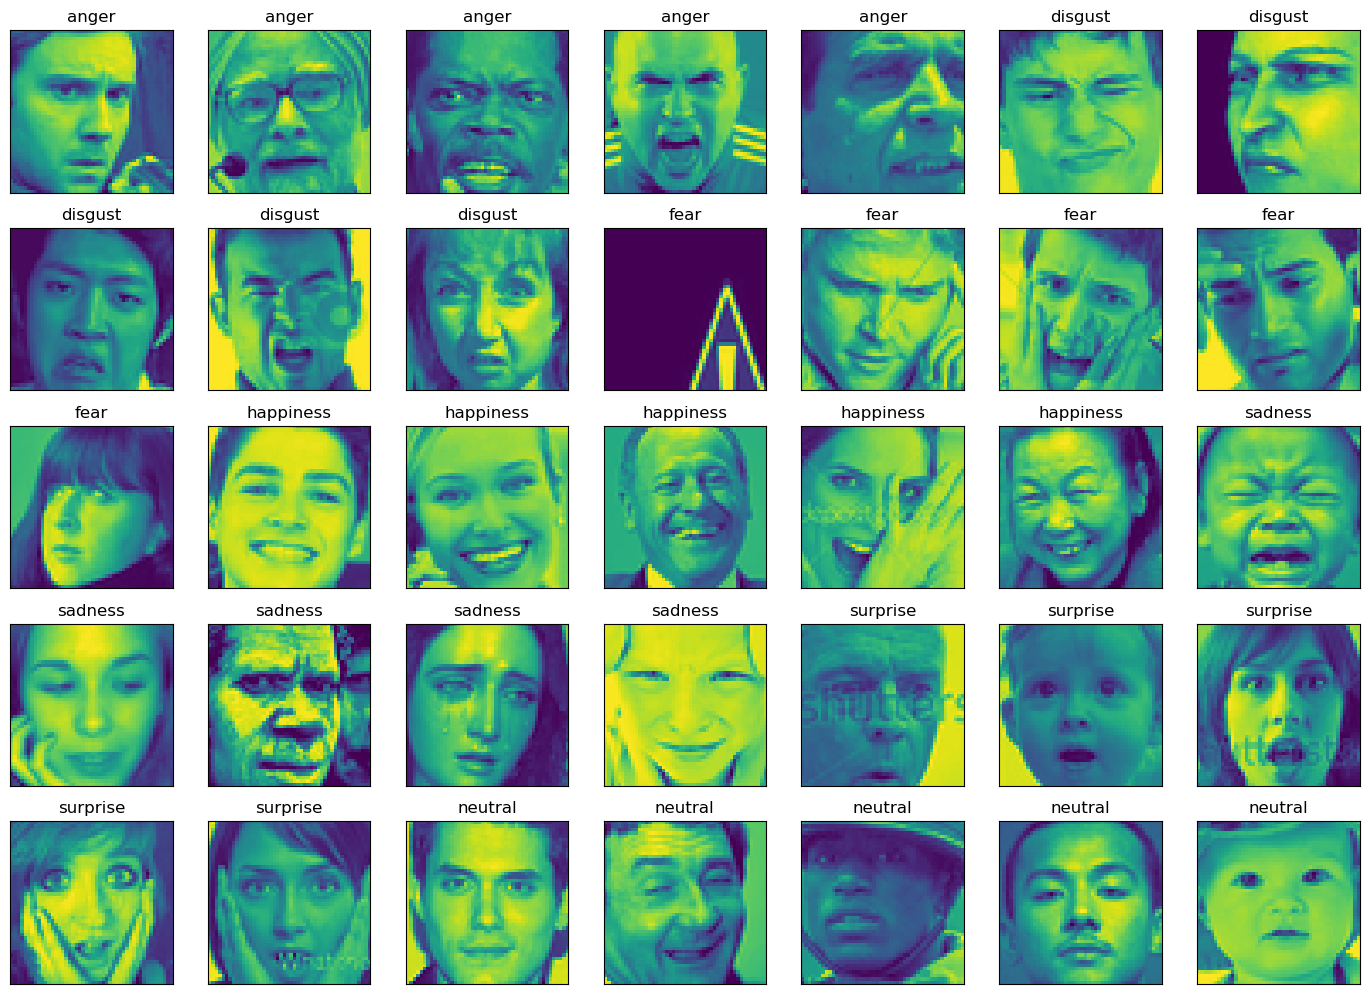

In [5]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [6]:
# Checking Emotion Class Distribution
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

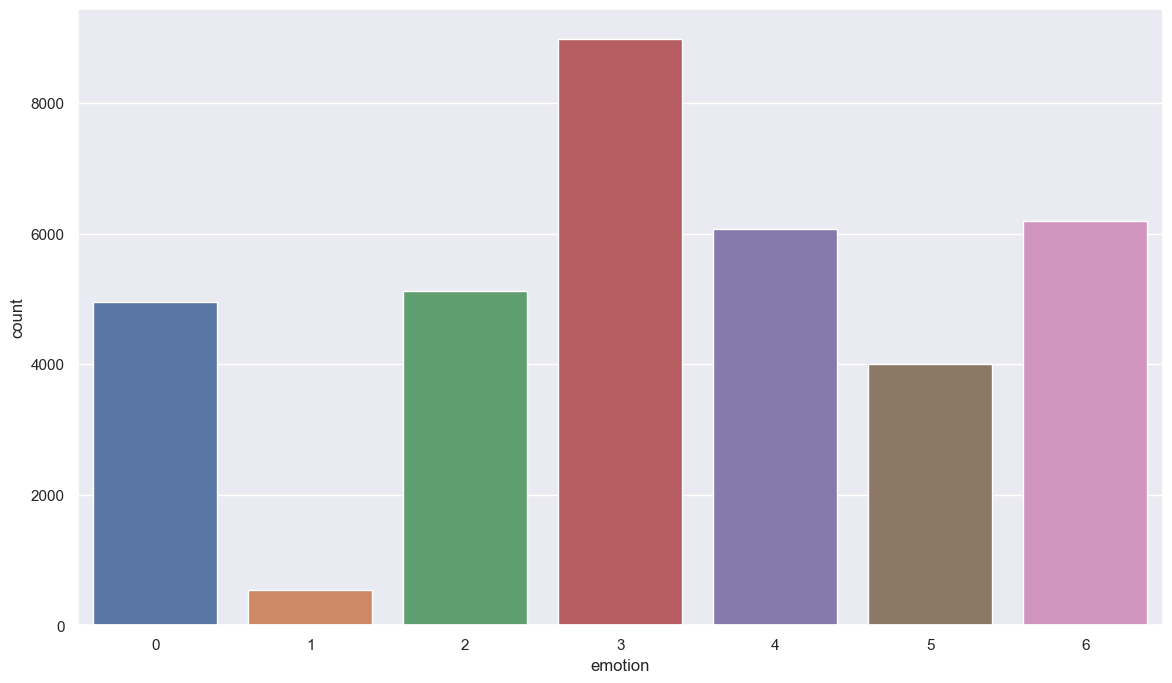

In [7]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [8]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [9]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [10]:
# Let's check the distributio of target data again after balancing
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [11]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    10 6 8 10 20 53 96 105 101 104 96 84 73 59 49 ...
62919    3 2 8 68 84 73 92 96 84 149 190 219 217 163 12...
62920    115 114 114 113 112 110 109 109 111 108 106 10...
62921    190 198 232 250 254 255 254 254 255 255 255 25...
62922    183 192 191 186 188 198 203 202 204 208 211 21...
Length: 62923, dtype: object

In [12]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [13]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [14]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [15]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [16]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [17]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                       

In [19]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoded arrays
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [21]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 139, validation_data=(x_test, y_test))

Epoch 1/139
1770/1770 [==============================] - 224s 127ms/step - loss: 1.8044 - accuracy: 0.2879 - val_loss: 1.6468 - val_accuracy: 0.3710
Epoch 2/139
1770/1770 [==============================] - 232s 131ms/step - loss: 1.5347 - accuracy: 0.4155 - val_loss: 1.4111 - val_accuracy: 0.4621
Epoch 3/139
1770/1770 [==============================] - 231s 130ms/step - loss: 1.3788 - accuracy: 0.4747 - val_loss: 1.2681 - val_accuracy: 0.5172
Epoch 4/139
1770/1770 [==============================] - 228s 129ms/step - loss: 1.2696 - accuracy: 0.5187 - val_loss: 1.1477 - val_accuracy: 0.5605
Epoch 5/139
1770/1770 [==============================] - 231s 131ms/step - loss: 1.1838 - accuracy: 0.5528 - val_loss: 1.0749 - val_accuracy: 0.5930
Epoch 6/139
1770/1770 [==============================] - 229s 129ms/step - loss: 1.1160 - accuracy: 0.5755 - val_loss: 1.0895 - val_accuracy: 0.5829
Epoch 7/139
1770/1770 [==============================] - 228s 129ms/step - loss: 1.0606 - accuracy: 0.5969

In [22]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

197/197 [==============================] - 6s 28ms/step - loss: 0.8198 - accuracy: 0.8611
Accuracy of our model on test data :  86.11155152320862 %
197/197 [==============================] - 6s 28ms/step - loss: 0.8198 - accuracy: 0.8611
Loss of our model on test data :  0.8197952508926392


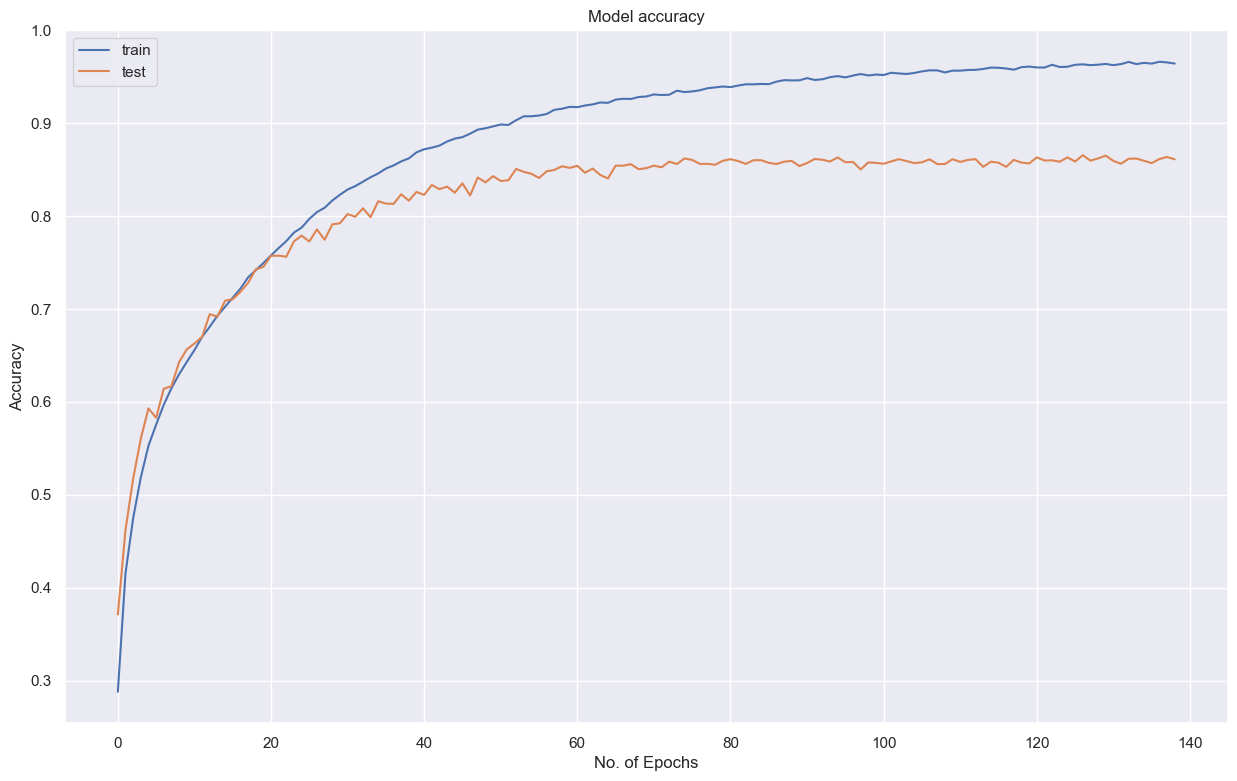

In [23]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

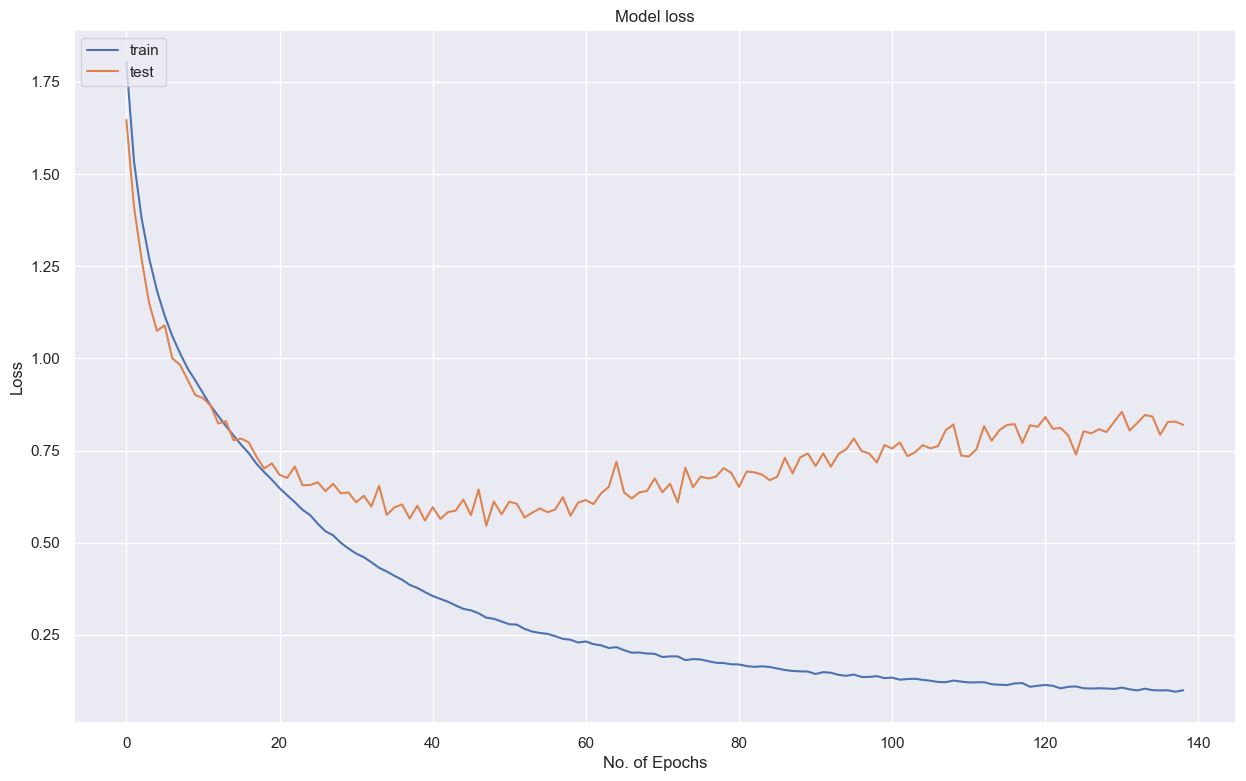

In [24]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Making Prediction on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 6s 28ms/step


[2, 5, 5, 6, 1, 6, 3, 4, 1, 2]

In [26]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [27]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       935
           1       0.99      1.00      1.00       895
           2       0.79      0.85      0.82       880
           3       0.89      0.80      0.84       906
           4       0.75      0.78      0.76       888
           5       0.94      0.96      0.95       869
           6       0.79      0.81      0.80       920

    accuracy                           0.86      6293
   macro avg       0.86      0.86      0.86      6293
weighted avg       0.86      0.86      0.86      6293



Text(179.75, 0.5, 'Truth')

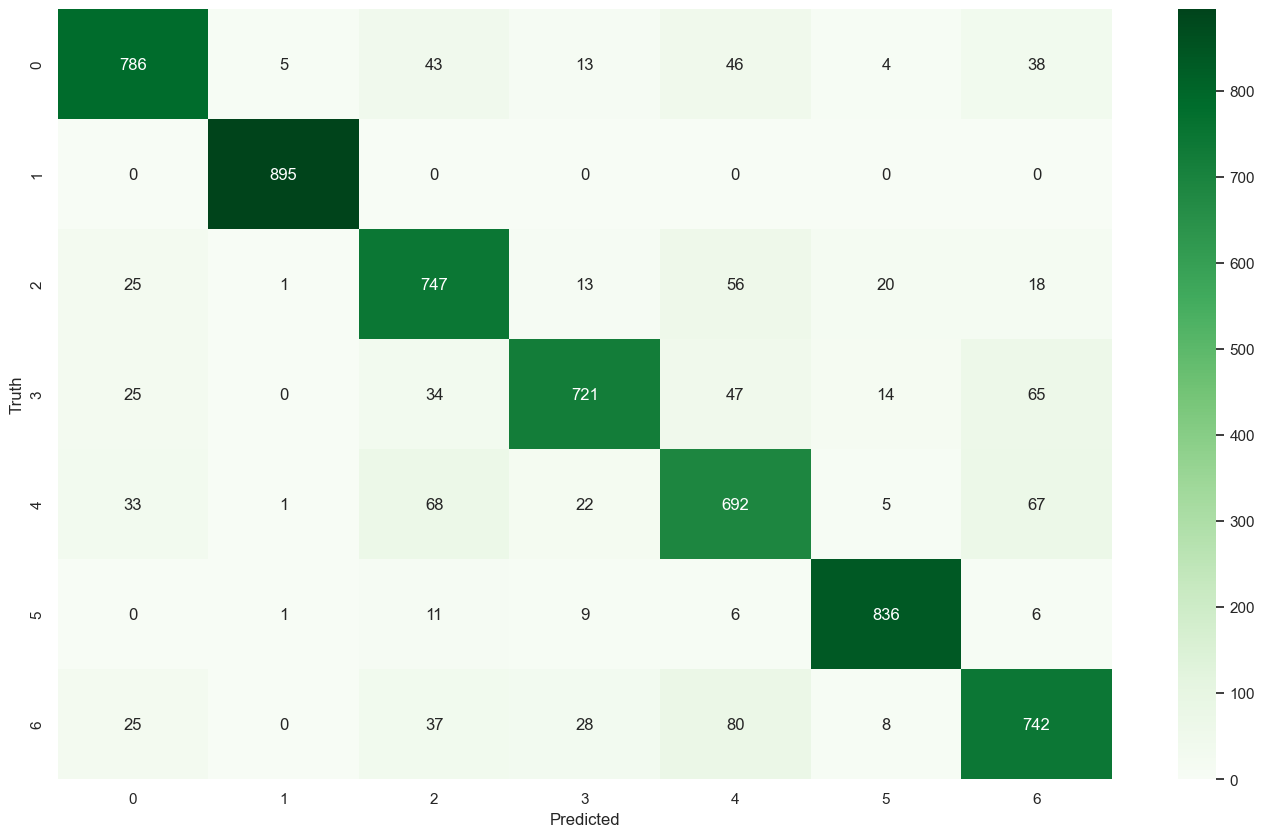

In [28]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
# Save the Model
model.save("fernew.hdf5")

/Users/vanjivakamsrimanthteja/Downloads/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:

fer_json = model.to_json()
with open("Facial Expression Recognition New.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fernew.h5")